# Collaborative filtering

A common problem is, instead of prediction, we wish to provide recommendations for items a user may like, based on prior individual-level data. The solution to this problem is called _collaborative filtering_.

The idea with, say, movie recommendation, is to find users who have similar preferences to you, and then find movies which similar users have liked, that you haven't seen.

Items, in a more general sense, can include links that you click on, diagnoses that are selected for patients, and so on.

The underlying idea is that there must be some underlying set of features, not necessarily labelled, which determine an association between users and items. The objective is to uncover _latent factors_ which determine this association.

In [1]:
from fastai.collab import *
from fastai.tabular.all import *

## Movie Lens dataset

In [2]:
path = untar_data(URLs.ML_100k)

In [3]:
path

Path('/home/jupyter/.fastai/data/ml-100k')

In [4]:
Path.BASE_PATH = path

In [5]:
path.ls()

(#23) [Path('ub.test'),Path('u3.base'),Path('ub.base'),Path('u4.base'),Path('u4.test'),Path('u1.base'),Path('ua.base'),Path('u.occupation'),Path('README'),Path('u.data')...]

The main table is `u.data`.

In [6]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', 
                      names=['user', 'movie', 'rating', 'timestamp'])

In [7]:
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [8]:
ratings.shape

(100000, 4)

In [9]:
ratings.rating.unique()

array([3, 1, 2, 4, 5])

In [10]:
len(ratings.movie.unique())

1682

In [11]:
len(ratings.user.unique())

943

In [12]:
top_movies = (ratings[['movie', 'user']]
              .groupby('movie')
              .count()
              .sort_values(by='user', ascending=False)[:10]
              .index
              .values
              .ravel()
             )
top_users = (ratings[ratings['movie'].isin(top_movies)]
              .groupby('user')
              .count()
              .sort_values(by='user', ascending=False)[:10]
              .index
              .values
              .ravel()
            )

movie_slice = (ratings[['user', 'movie', 'rating']]
 .pivot(index='user', columns='movie')
 .loc[top_users, (slice(None), top_movies)]
)

In [13]:
movie_slice.style.background_gradient(cmap='RdYlGn', vmin=1, vmax=5)

The objective of collaborative filtering is to fill in the blanks of this table, and recommend the movie the user is most likely to like to watch next.

This is achieved by associating a set of **latent factors** with each item, and a set of corresponding latent factors for each user. The prediction is then the dot-product between the latent factors and the weights.

 <img src="./figures/collab.png" style="width:1000px"> 

## Create DataLoaders

In [14]:
movies = pd.read_csv(path/"u.item", delimiter='|', encoding='latin-1', usecols=(0,1), 
                     names=('movie', 'title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [15]:
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [16]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


We could use the `DataBlocks` API, or just use the built-in factory method for making our `DataLoaders`

In [17]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,85,Spanking the Monkey (1994),3
1,501,Rumble in the Bronx (1995),3
2,536,Muppet Treasure Island (1996),3
3,152,Back to the Future (1985),4
4,85,Living in Oblivion (1995),4
5,231,"Lost World: Jurassic Park, The (1997)",4
6,236,Dead Poets Society (1989),1
7,535,It Happened One Night (1934),4
8,863,Lost Highway (1997),5
9,590,"First Wives Club, The (1996)",3


In [18]:
dls.classes

{'user': (#944) ['#na#',1,2,3,4,5,6,7,8,9...],
 'title': (#1665) ['#na#',"'Til There Was You (1997)",'1-900 (1994)','101 Dalmatians (1996)','12 Angry Men (1957)','187 (1997)','2 Days in the Valley (1996)','20,000 Leagues Under the Sea (1954)','2001: A Space Odyssey (1968)','3 Ninjas: High Noon At Mega Mountain (1998)'...]}

Create latent factors

In [19]:
n_users = len(dls.classes['user'])
n_titles = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_titles, n_factors)

To get the two appropriate sets of latent factors for a (user, movie) pair, we need to look up the corresponding index of both users and movies in the `user_factors` and `movie_factors` matricies. But "_look up in an index_" is not an operation that deep learning models know how to do. They require **differentiable** operations such as matrix multiplications and non-linear activation functions.

However, we can represent a look-up by using one-hot encoded vectors!

In [20]:
one_hot(2,5)

tensor([0, 0, 1, 0, 0], dtype=torch.uint8)

In [21]:
user_factors.t() @ one_hot(3, n_users).float()

tensor([-0.2366, -0.0309, -0.4421, -0.7186, -1.0488])

In [22]:
user_factors[3]

tensor([-0.2366, -0.0309, -0.4421, -0.7186, -1.0488])

Since a matrix multiplication has a well-defined gradient, we can use backprop and our regular SGD machinery to perform learning.

We could do this for the whole set of users, and that would be a perfectly acceptable way to build collaborative filtering models. However, using matrix multiplication to perform indexing is not very memory/time efficient. 

Most deep learning libraries, including PyTorch, include a special layer that does this for us -- called an **embedding**. An embedding indexes into a vector using an integer, but has its derivative calculated in a way which is identical to a matrix multiplication with one-hot-encoded vectors. So

"**Embedding** = multiplying by a one-hot-encoded matrix, using a computational shortcut such that it can be implemented simply by indexing directly"

## Collaborative filtering from scratch

When creaing a new PyTorch Module, we must inherit from `Module`.

In [23]:
Module

fastai.torch_core.Module

When calling a module, PyTorch will call a method called `forward` and pass along any parameters that are included in the call. This is where you put the actual computation. So, to define a dot product model, we may write:

In [24]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
    
    def forward(self, x):
        users = self.user_factors(x[:,0])  # for every user, get the corresponding latent factors
        movies = self.movie_factors(x[:,1]) # for every movie, get the corresponding latent factors
        
        # perform a dot product for each (user, movie). dim=0 is the mini-batch dimension.
        return (users * movies).sum(dim=1) 
                 

In [25]:
x, y = dls.one_batch()

In [26]:
x.shape

torch.Size([64, 2])

In [27]:
x[:5]

tensor([[ 296,  304],
        [ 666,  447],
        [ 645, 1485],
        [ 303,   42],
        [ 432,  856]], device='cuda:0')

The first column consists of users, and the second column consists of items.

## Train model

Previously we have used special functions such as `cnn_learner` which sets everything up for us for a CNN application. Since we're doing things from scratch here, we'll use the plain `Learner` class.

In [28]:
model = DotProduct(n_users, n_titles, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [29]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.321491,1.296349,00:06
1,1.085333,1.080703,00:06
2,0.957924,0.977100,00:06
3,0.835392,0.892612,00:06
4,0.776876,0.875521,00:06


We can make the model a little better by forcing the predictions to be between 0-5. Empirically, it's found that things work better if you can go a little over 5:

In [30]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
    
    def forward(self, x):
        users = self.user_factors(x[:,0])  # for every user, get the corresponding latent factors
        movies = self.movie_factors(x[:,1]) # for every movie, get the corresponding latent factors
        
        # perform a dot product for each (user, movie). dim=0 is the mini-batch dimension.
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range) 
                 

In [31]:
model = DotProduct(n_users, n_titles, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.976325,0.973851,00:07
1,0.883897,0.896304,00:06
2,0.656768,0.861339,00:06
3,0.481636,0.869111,00:06
4,0.366966,0.873295,00:06


We should also include a bias term, for systematic effects in movies/users.

In [32]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        self.user_factors = Embedding(n_users, n_factors)        
        self.user_bias = Embedding(n_users, 1)
        
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        
        self.y_range = y_range
    
    def forward(self, x):
        users = self.user_factors(x[:,0])  # for every user, get the corresponding latent factors
        movies = self.movie_factors(x[:,1]) # for every movie, get the corresponding latent factors        
        
        res = (users * movies).sum(dim=1, keepdim=True)  # keepdims -- not sure why
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        
        # perform a dot product for each (user, movie). dim=0 is the mini-batch dimension.
        return sigmoid_range(res, *self.y_range) 
                 

In [33]:
model = DotProductBias(n_users, n_titles, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.950166,0.933850,00:07
1,0.826388,0.849396,00:07
2,0.619086,0.842885,00:07
3,0.392377,0.864537,00:07
4,0.279823,0.871482,00:07


This is starting to overfit quite quickly -- with only 4 epochs the validation loss is starting to increase. We need some kind of regularization to prevent overfitting.

## Weight decay

Promotes finding smooth functions by penalizing large parameter values. `wd` is a hyperparameter of the model which augments the loss function.

In [34]:
model = DotProductBias(n_users, n_titles, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1) # with weight decay

epoch,train_loss,valid_loss,time
0,0.938515,0.954939,00:07
1,0.836104,0.874313,00:07
2,0.755458,0.829546,00:07
3,0.600833,0.816183,00:07
4,0.492354,0.816453,00:07


That's looking a bit better.

## Creating an Embedding module from scratch

An embedding is just an indexing into an array. Let's create our own layer.

A layer is usually created by inheriting from `Module`. Optimizers require being able to grab all the parameters of a module by calling the `parameters` method, so that it can be optimized with backprop. This doesn't happen automatically:

In [35]:
class DummyLayer(Module):
    def __init__(self): self.a = torch.ones(3)  # a parameter. Or is it?

L(DummyLayer().parameters())

(#0) []

To tell `Module` that we want to treat a tensor as a parameter, we have to wrap it in `nn.Parameter`. All it does is add `requires_grad_` and functions as a marker for differentiable parameters.

In [36]:
class DummyLayer(Module):
    def __init__(self): self.a = nn.Parameter(torch.ones(3))  # a parameter. 

L(DummyLayer().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

PyTorch modules use `nn.Parameter` for any trainable parameters automatically, hence why we haven't used `nn.Parameter` until now

In [37]:
class DummyLayer(Module):
    def __init__(self): self.a = nn.Linear(1,3,bias=False)

L(DummyLayer().parameters())

(#1) [Parameter containing:
tensor([[ 0.8326],
        [ 0.4541],
        [-0.2158]], requires_grad=True)]

So, we can create a tensor as a parameter, with random normal initialization, like so:

In [39]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

Now we can just replace `Embedding` with `create_params` in `DotProductBias`.

In [50]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        self.user_factors = create_params([n_users, n_factors])        
        self.user_bias = create_params([n_users])
        
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        
        self.y_range = y_range
    
    def forward(self, x):
        users = self.user_factors[x[:,0]]  # for every user, get the corresponding latent factors
        movies = self.movie_factors[x[:,1]] # for every movie, get the corresponding latent factors        
        
        res = (users * movies).sum(dim=1) # get rid of keepdim -- not sure why
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        
        # perform a dot product for each (user, movie). dim=0 is the mini-batch dimension.
        return sigmoid_range(res, *self.y_range) 
                 

In [51]:
model = DotProductBias(n_users, n_titles, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1) # with weight decay

epoch,train_loss,valid_loss,time
0,0.950661,0.935671,00:08
1,0.861542,0.864648,00:08
2,0.726139,0.825717,00:08
3,0.578182,0.814955,00:08
4,0.476068,0.815265,00:08


## Interpreting Embeddings and biases

In [61]:
movie_bias = learn.model.movie_bias.squeeze()
idxs_lowest = movie_bias.argsort()[:5]
idxs_highest = movie_bias.argsort(descending=True)[:5]

In [62]:
[dls.classes['title'][i] for i in idxs_lowest]

['Children of the Corn: The Gathering (1996)',
 'Island of Dr. Moreau, The (1996)',
 "Stephen King's The Langoliers (1995)",
 'Amityville: A New Generation (1993)',
 'Mr. Magoo (1997)']

These are the 5 movies with the smallest bias -- effectively the movies people liked the least, even after accounting for the latent factors.

In [63]:
[dls.classes['title'][i] for i in idxs_highest]

['L.A. Confidential (1997)',
 'Titanic (1997)',
 'Usual Suspects, The (1995)',
 'Good Will Hunting (1997)',
 "Schindler's List (1993)"]

And these are the most popular

We can use PCA to have a look at where movies sit in the 50-dimensional space defined by the movie latent space

In [64]:
g = ratings.groupby('title')['rating'].count()
most_reviewed_movies = g.sort_values(ascending=False).index.values[:1000]

In [66]:
most_reviewed_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in most_reviewed_movies])

In [68]:
movie_w = learn.model.movie_factors[most_reviewed_idxs].cpu().detach()

In [70]:
movie_pca = movie_w.pca(k=3)
fac0, fac1, fac2 = movie_pca.t()

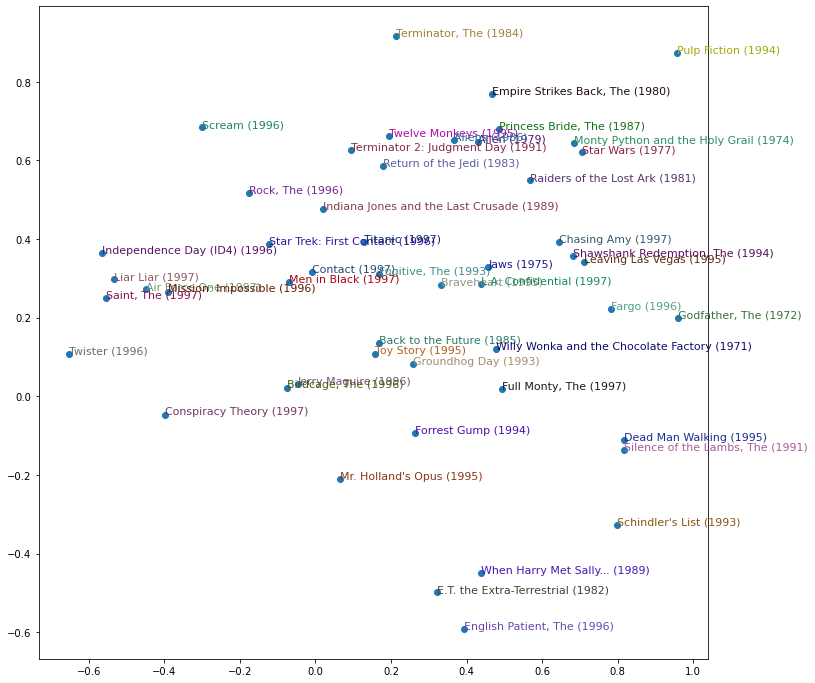

In [73]:
X = fac0[:50]
Y = fac2[:50]
plt.figure(figsize=(12,12))
plt.scatter(X,Y)
for i, x, y in zip(most_reviewed_movies, X, Y):
    plt.text(x, y, i, color=np.random.rand(3)*0.7, fontsize=11)

The horizontal axis seems somthing like "critical acclaim". The vertical axis seems like a romance/action axis.

## Collaborative filtering with fastai

`collab_learner` has the same structure as `DotProductBias` above

In [74]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.942193,0.950799,00:07
1,0.879145,0.871332,00:07
2,0.737970,0.827587,00:07
3,0.592858,0.815005,00:07
4,0.470249,0.816069,00:07


In [75]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

`u_` = user, `i_` = item

## Embedding distance

We can use treat the embedding space as Euclidean. Using cosine similarity (i.e. cosine of the angle between the vectors) to find the most similar movie to e.g. Silence of the Lambs

In [78]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1:4]
dls.classes['title'][idx]

(#3) ['Letter From Death Row, A (1998)','Prefontaine (1997)','Everest (1998)']

## Introducing non-linearity via deep learning

The dot product is linear in the latent factors of users and items. But what if there exists non-linear interactions between the factors for users and items? The model above can't capture this. We can, however, augment the model to contain a neural network.

Instead of using a dot-product, we will concatenate the latent factors for a (user, item) pair, and then pass that vector into a neural network.

In [82]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1)
        )
        self.y_range = y_range
    
    def forward(self, x):
        embs = self.user_factors(x[:,0]), self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

fastai has a heuristic for choosing the number of embeddings based on the the data. Note that now we're not doing a dot-product, we can have different sized embeddings for the users and items.

In [83]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [84]:
model = CollabNN(*embs)

In [86]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.942887,0.943275,00:08
1,0.899684,0.902654,00:08
2,0.861160,0.878192,00:08
3,0.804407,0.860347,00:08
4,0.779790,0.862850,00:08


We can also use the fastai factory method, and make different-sized models

In [87]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.980523,0.967889,00:09
1,0.909785,0.907085,00:09
2,0.879704,0.883348,00:09
3,0.839882,0.855051,00:09
4,0.776684,0.854197,00:09
